In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass
from pymarkovchain import MarkovChain
from functions import *
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
df = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized.txt')
df_scores = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

In [3]:
df2 = df[df.Activity == 'a1']
blocks = get_blocks(df2,get_students(),add_spaces = True)
sequences = '.'.join(blocks.values())

In [4]:
mc = MarkovChain()
mc.generateDatabase(sequences)
chain_probs = mc.db

In [5]:
G = nx.Graph()
for last_actions,probs in chain_probs.iteritems():
    if len(last_actions) == 1:
        last_action = last_actions[0]
        for next_action,p in probs.iteritems():
            G.add_edge(last_action, next_action, weight = p)
G.remove_nodes_from([''])
G.nodes()

['B', 'E', 'I', 'O', 'P', 'S', 'R', 'T', 'X']

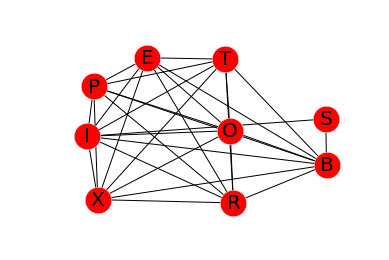

In [6]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=700)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
plt.axis('off')
plt.savefig("weighted_graph.png") # save as png